In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from emoji import get_emoji_regexp
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from pandarallel import pandarallel
from src.visualization.emoji_plotting import plot_emoji_barplot, emoji_scatter

pandarallel.initialize(nb_workers=8)
from settings import AMBIGUITY_CLUSTER
from src.data.utils import save_to_csv, parallelize_dataframe, apply_find_emojis

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
print("Load data...")
num_cpus = 30
emoji_regex = get_emoji_regexp()
path = "/scratch/czestoch/emojitweets-01-04-2018.txt.gz"
tweets = pd.read_table(path, header=None, lineterminator='\n', quoting=3, encoding='utf-8')
tweets = tweets.rename({0: "tweet"}, axis=1)
tweets = tweets.drop_duplicates('tweet')
tweets['emojis'] = parallelize_dataframe(tweets, apply_find_emojis, n_cores=num_cpus)

Load data...


  0%|          | 0/30 [00:00<?, ?it/s]

In [3]:
len(tweets)

11018878

In [5]:
one_emoji_tweets = tweets[tweets.emojis.apply(len) == 1]
print(f"There are: {len(one_emoji_tweets)} tweets with one emoji only")

There are: 5754879 tweets with one emoji only


In [6]:
one_emoji_tweets.emojis = one_emoji_tweets.emojis.apply(lambda x: x[0])
df2 = one_emoji_tweets.groupby("emojis").tweet.count()
df2 = df2.to_frame().reset_index()

/home/czestoch/.local/lib/python3.7/site-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [7]:
sns.set(rc={'figure.figsize':(15, 7)}, font_scale=1.5)
sns.set_style("white", {'axes.grid' : True})

In [8]:
tweets = tweets.explode("emojis")
df1 = tweets.groupby("emojis").tweet.count().to_frame().reset_index()
del tweets

In [9]:
contextfree_emojis = pd.read_csv(AMBIGUITY_CLUSTER).emoji.unique()
print(f"There are: {len(one_emoji_tweets[one_emoji_tweets.emojis.isin(contextfree_emojis)])} one emoji tweets with emojis from context-free dataset")

There are: 4870877 one emoji tweets with emojis from context-free dataset


In [10]:
print(f"We have: {len(set(one_emoji_tweets.emojis.unique()).intersection(set(contextfree_emojis)))} emojis in one emoji tweets that are also in context-free emojis")

We have: 1178 emojis in one emoji tweets that are also in context-free emojis


In [11]:
df3 = one_emoji_tweets[one_emoji_tweets.emojis.isin(contextfree_emojis)]
df3 = df3.groupby("emojis").count()

Now we will only consider tweets with one emoji containing emojis from context-free part

In [14]:
tweets = one_emoji_tweets[one_emoji_tweets.emojis.isin(contextfree_emojis)]

We'll try to determine a threshold for number of characters

In [ ]:
tweets["num_chars"] = tweets.tweet.parallel_apply(len)
print(f"Number of tweets: {len(tweets):,}")

In [21]:
tweets.num_chars.describe()

count    4.870877e+06
mean     5.184062e+01
std      3.262822e+01
min      5.000000e+00
25%      2.500000e+01
50%      4.400000e+01
75%      7.400000e+01
max      3.380000e+02
Name: num_chars, dtype: float64

<AxesSubplot:xlabel='num_chars'>

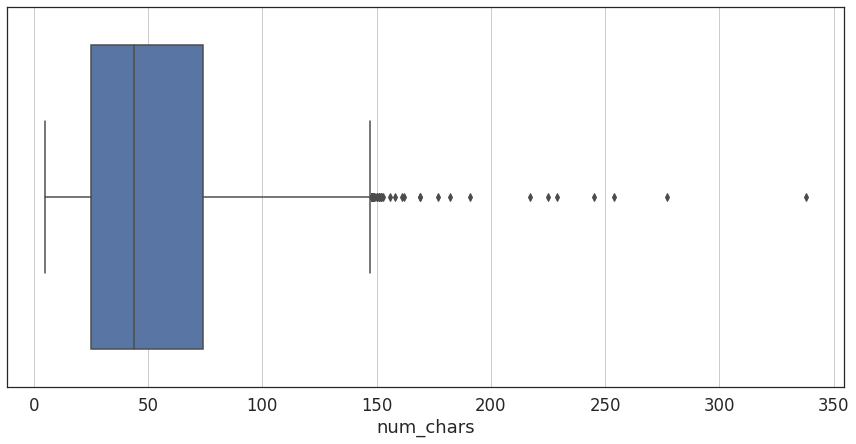

In [23]:
sns.boxplot(data=tweets, x="num_chars")

We'll use the median as it takes into account the outlying tweets with suspension railway emoji where there are only two random words

In [57]:
chars_thresh = tweets.num_chars.median()

In [47]:
df = tweets[tweets.emojis == '🚟'].num_chars > chars_thresh
tweets.loc[df[df == True].index.values, :]

,tweet,emojis,num_chars
9649802,$CRON . Stock that make new highs tend to make...,🚟,107
10372149,Follow everyone who retweets and likes this 🚟,🚟,45
10772959,Yall Saying you don't fuck with my bro? FUUCCC...,🚟,53
16265348,"i'm doing the emoji poll thing, too. here is t...",🚟,121
16399504,I think I might start using this account again 🚟,🚟,48
17625472,🚟 This is the least used emoji on twitter. Let...,🚟,98
18214580,🚟 Join the Zelda + Skyrim giveaway at who who ...,🚟,63


In [49]:
print(f"Number of tweets with > {chars_thresh} characters: {len(tweets[tweets.num_chars > chars_thresh]):,}")

Number of tweets with > 44 characters: 2,406,016


In [52]:
print(f"Number of emojis in tweets with > {chars_thresh} characters: {tweets[tweets.num_chars > chars_thresh].emojis.nunique():,}")

Number of emojis in tweets with > 44 characters: 1,170


In [59]:
df4 = tweets[tweets.num_chars > chars_thresh].groupby("emojis").count()

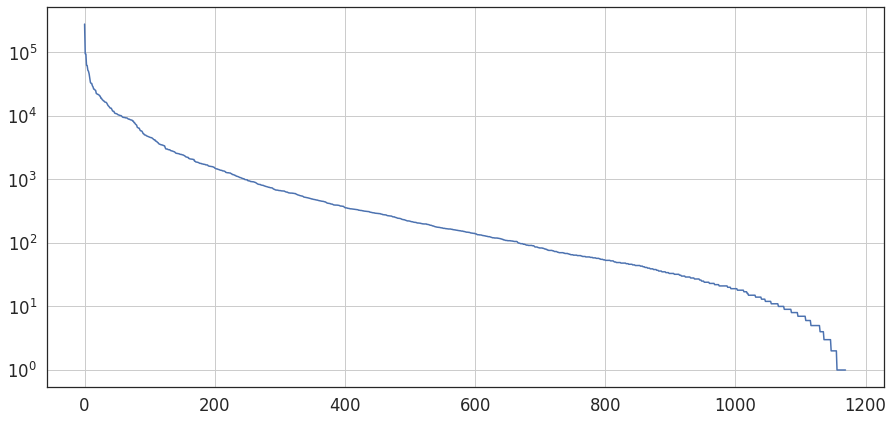

In [60]:
plt.plot(df4.tweet.sort_values(ascending=False).values)
plt.yscale("log")

In [75]:
print(f"Number of emojis if we consider emojis that have more than 100 tweets: {len(df4[df4.tweet.sort_values(ascending=False) > 100])}")

Number of emojis if we consider emojis that have more than 100 tweets: 666


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


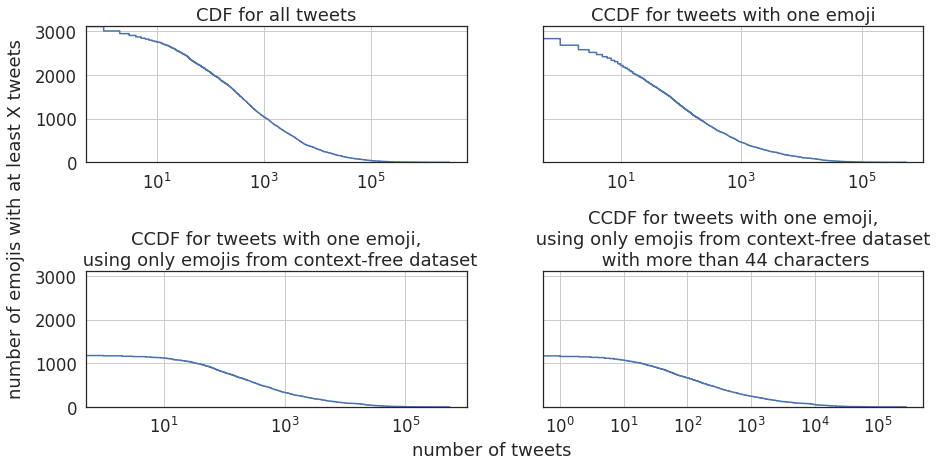

In [76]:
fig, axes = plt.subplots(2, 2, sharex=False, sharey=True)

ax1 = sns.ecdfplot(data=df1, x="tweet", stat='count', complementary=True, ax=axes[0][0])
ax1.set_title("CDF for all tweets")
ax1.set_xscale("log")
ax1.set_xlabel("")
ax1.set_ylabel("")

ax2 = sns.ecdfplot(data=df2, x="tweet", stat='count', complementary=True, ax=axes[0][1])
ax2.set_title("CCDF for tweets with one emoji")
ax2.set_xscale("log")
ax2.set_xlabel("")
ax2.set_ylabel("")

ax3 = sns.ecdfplot(data=df3, x="tweet", stat='count', complementary=True, ax=axes[1][0])
ax3.set_title("CCDF for tweets with one emoji,\n using only emojis from context-free dataset")
ax3.set_xscale("log")
ax3.set_xlabel("")
ax3.set_ylabel("")

ax4 = sns.ecdfplot(data=df4, x="tweet", stat='count', complementary=True, ax=axes[1][1])
ax4.set_title(f"CCDF for tweets with one emoji,\n using only emojis from context-free dataset \n with more than {int(chars_thresh)} characters")
ax4.set_xscale("log")
ax4.set_xlabel("")
ax4.set_ylabel("")

fig.set
fig.text(0.5, 0.04, 'number of tweets', ha='center', va='center')
fig.text(0.06, 0.5, 'number of emojis with at least X tweets', ha='center', va='center', rotation='vertical')
plt.subplots_adjust(wspace=0.2, hspace=0.8)

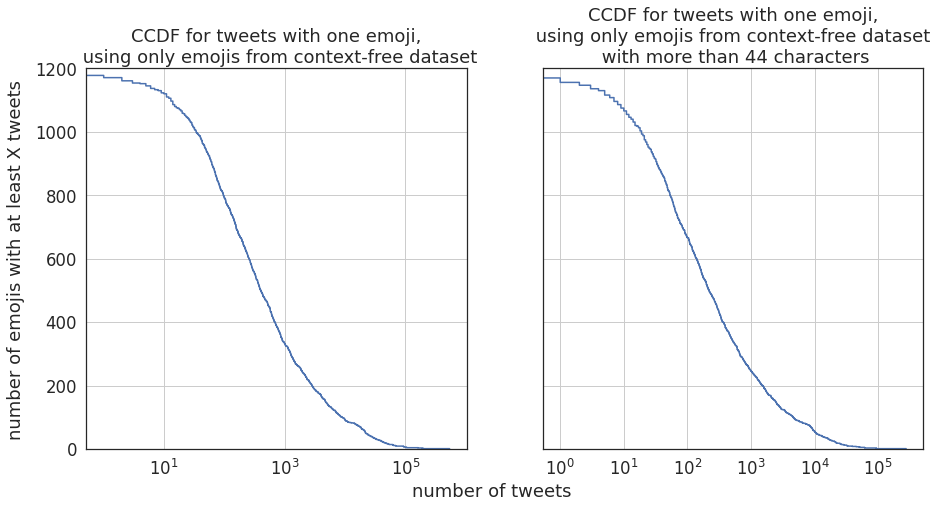

In [63]:
fig, axes = plt.subplots(1, 2, sharex=False, sharey=True)

ax3 = sns.ecdfplot(data=df3, x="tweet", stat='count', complementary=True, ax=axes[0])
ax3.set_title("CCDF for tweets with one emoji,\n using only emojis from context-free dataset")
ax3.set_xscale("log")
ax3.set_xlabel("")
ax3.set_ylabel("")
ax3.set_ylim(0, 1200);

ax4 = sns.ecdfplot(data=df4, x="tweet", stat='count', complementary=True, ax=axes[1])
ax4.set_title(f"CCDF for tweets with one emoji,\n using only emojis from context-free dataset \n with more than {int(chars_thresh)} characters")
ax4.set_xscale("log")
ax4.set_xlabel("")
ax4.set_ylabel("")
ax4.set_ylim(0, 1200);

fig.text(0.5, 0.04, 'number of tweets', ha='center', va='center')
fig.text(0.06, 0.5, 'number of emojis with at least X tweets', ha='center', va='center', rotation='vertical')
plt.subplots_adjust(wspace=0.2, hspace=0.8)

Now we only have tweets that have more than 44 characters with emojis from context-free dataset that have more than 100 tweets

In [80]:
tweets = tweets[tweets.num_chars > chars_thresh]
tweets = tweets[tweets.emojis.isin(df4[df4.tweet > 100].index.values)]
tweets.head()

,tweet,emojis,num_chars
5,NEW || Zach &amp; Jack at Limelight tonight! (...,©️,67
10,This is one of my favorite songs to sing in th...,❤️,59
11,Took my goat to get groomed for the first time 😂,😂,48
12,NEW || Zayn in NYC today! (Yes its outside G’s...,©️,93
21,Look at the reactions from Jcole’s listening p...,😭,51


In [86]:
tweets.emojis.unique()

array(['©️', '❤️', '😂', '😭', '🙏', '💣', '💓', '💪', '😮', '💕', '💐', '✨', '💖',
       '🤣', '😍', '🍋', '🛫', '🤔', '📺', '🌻', '🥃', '🤖', '📻', '🤧', '👍', '🙄',
       '🙃', '💯', '😃', '⚾', '💛', '🎒', '🐑', '🎉', '👀', '🎃', '😉', '😩', '💞',
       '😕', '🐲', '🌺', '😎', '😔', '👉', '⬆️', '😯', '😁', '💙', '💧', '🔥', '😱',
       '🚨', '😊', '‼️', '📰', '🎥', '🎬', '📆', '😅', '👌', '™️', '💑', '😢', '🤤',
       '📷', '🤪', '👏', '😘', '👼', '😐', '🤬', '📸', '💅', '👮', '💟', '😜', '🛰️',
       '💚', '😀', '⏩', '💬', '🎶', '👶', '📹', '🧡', '😼', '🌸', '➡️', '☹️', '☺️',
       '😡', '🐯', '⬇️', '😪', '🌹', '🎧', '😏', '💗', '👑', '😙', '😑', '💌', '🎸',
       '😳', '💜', '☀️', '🎼', '🙌', '🦄', '🗞️', '♥️', '🤗', '😬', '🥇', '💀', '🍴',
       '😰', '😋', '👋', '😌', '😒', '✌️', '😤', '🤑', '🔫', '🖤', '💥', '🤠', '😗',
       '🐝', '🐘', '😆', '💔', '⭐', '🥀', '⚠️', '😶', '👅', '🖥️', '❄️', '👿', '🙂',
       '🎮', '👇', '😝', '🎨', '🏈', '🙈', '🅱️', '🎵', '💃', '✈️', '🍂', '😞', '😈',
       '➕', '🤮', '🌷', '🏒', '🌀', '🌚', '🌱', '💋', '🙇', '💦', '🍉', '🔙', '🐶',
       '🍹', '🗿', '📖', '🧐', '🐴', '🌎', '❗', '💎'

In [95]:
equalized = tweets.groupby("emojis").sample(n=100, replace=False).reset_index()

In [99]:
save_to_csv(equalized[["tweet", "emojis"]], "/scratch/czestoch/cleaned_equalized_tweets.csv")